In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d tolgadincer/labeled-chest-xray-images
!unzip \*.zip  && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/NORMAL-2558319-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2558319-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2559035-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2559035-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2565226-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2568157-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2597757-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2597757-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-263932-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2646645-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2646923-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2655558-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2659844-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2675017-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2675017-00

In [4]:
train_dataset_path = 'chest_xray/train'
val_dataset_path = 'chest_xray/test'

batch_size = 32
img_height = 100
img_width = 100

train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  val_dataset_path,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5232 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [8]:
for Class in [train_ds, val_ds]:
    print(Class.class_names)
    
class_names = ['NORMAL', 'PNEUMONIA']

['NORMAL', 'PNEUMONIA']
['NORMAL', 'PNEUMONIA']


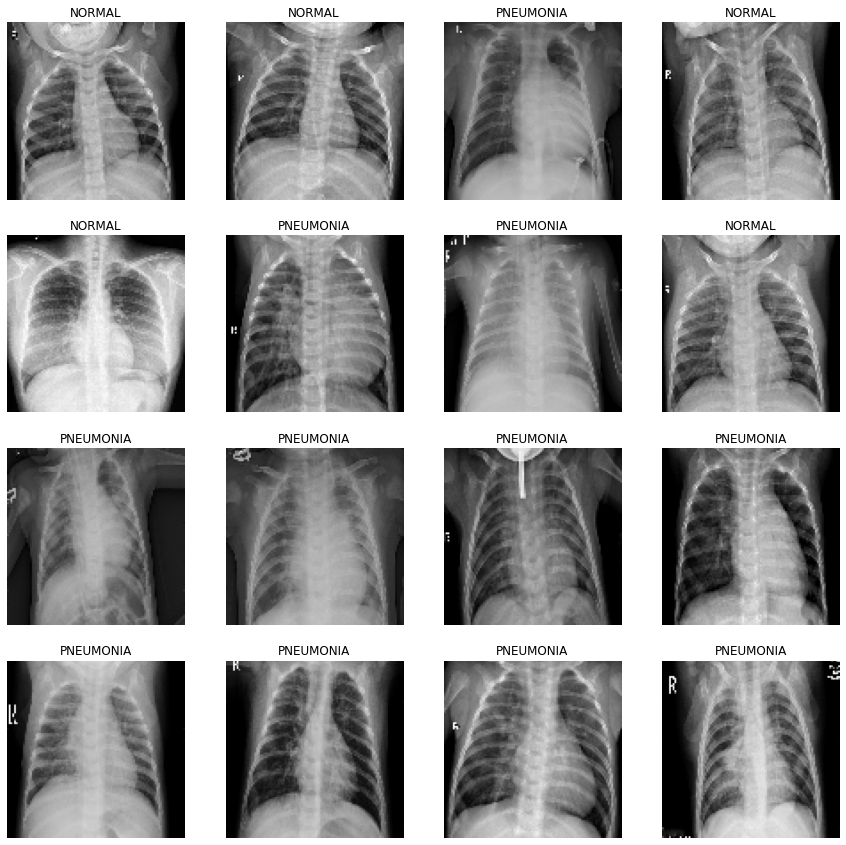

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [10]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 100, 100, 3)
(32,)


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Epoch 1/25
164/164 [==============================] - 59s 345ms/step - loss: 0.4356 - accuracy: 0.8068 - val_loss: 0.3886 - val_accuracy: 0.8045
Epoch 2/25
164/164 [==============================] - 59s 357ms/step - loss: 0.2520 - accuracy: 0.8979 - val_loss: 0.3345 - val_accuracy: 0.8622
Epoch 3/25
164/164 [==============================] - 62s 378ms/step - loss: 0.1966 - accuracy: 0.9230 - val_loss: 0.2535 - val_accuracy: 0.8894
Epoch 4/25
164/164 [==============================] - 57s 350ms/step - loss: 0.1786 - accuracy: 0.9249 - val_loss: 0.3308 - val_accuracy: 0.8478
Epoch 5/25
164/164 [==============================] - 56s 339ms/step - loss: 0.1712 - accuracy: 0.9344 - val_loss: 0.2900 - val_accuracy: 0.8878
Epoch 6/25
164/164 [==============================] - 56s 339ms/step - loss: 0.1509 - accuracy: 0.9404 - val_loss: 0.6628 - val_accuracy: 0.7756
Epoch 7/25
164/164 [==============================] - 59s 360ms/step - loss: 0.1618 - accuracy: 0.9343 - val_loss: 0.4121 - val_ac

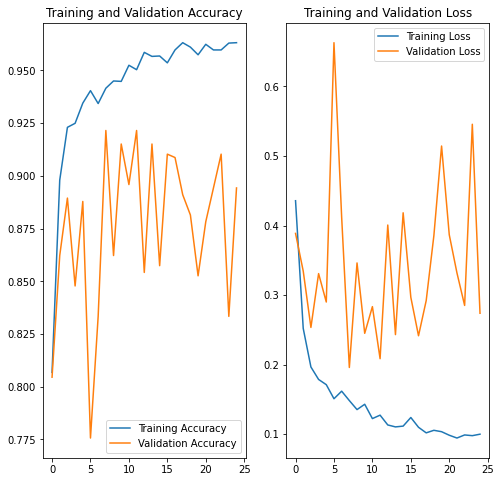

In [14]:
num_classes = len(class_names)

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs=25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



In [15]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 100, 100, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 50, 50, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 50, 50, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                  

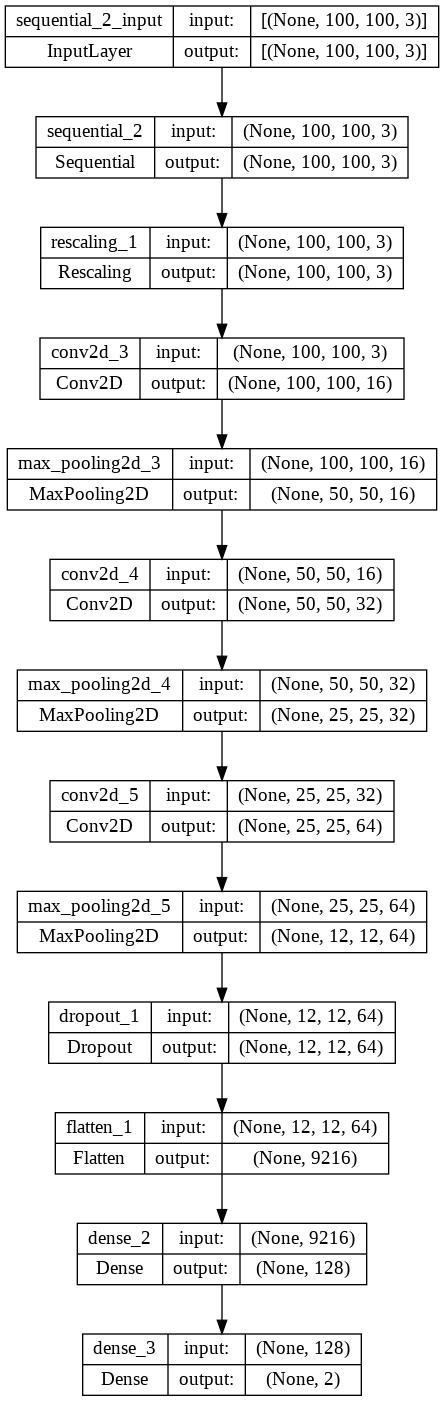

In [16]:
img_file = './model_arch.png'

tf.keras.utils.plot_model(model, to_file=img_file, show_shapes=True, show_layer_names=True)

In [18]:
# Saving the model for Future Inferences

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")